# Imports 


In [ ]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Changing directory to Session 10 project folder
% cd /content/gdrive/My Drive/TSAI-EVA-7.0/10_Object_Localization/

/content/gdrive/My Drive/TSAI-EVA-7.0/10_Object_Localization


In [ ]:
import torch.optim as optim
import torch.nn as nn

In [ ]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd

# Data

id: the class id, height: height of image, width: width of image, bbox: [x, y, width, height] where x, y: the upper-left coordinates of the bounding box

In [ ]:
coco_data_labels = ['id', 'height_image', 'width_image', 'upper_left_coord x', 'upper_left coord y', 'width bbox', 'height bbox']

In [ ]:
coco_data = []
with open('./data/sample_coco.txt') as file:
    for line in file:
        l = line.rstrip()
        res = [int(i) for i in re.findall(r'\d+', l)]
        coco_data.append(res)
coco_data = np.array(coco_data)

In [ ]:
coco_classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis','snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

## Class distributions

In [ ]:
ids = coco_data[:, 0]
class_labels = [coco_classes[i] for i in ids]

In [ ]:
data = np.transpose([ids, class_labels])
df = pd.DataFrame(data, columns=['ids', 'class_labels'])

In [ ]:
df.head()

,ids,class_labels
0,0,person
1,1,bicycle
2,3,motorcycle
3,34,baseball bat
4,20,elephant


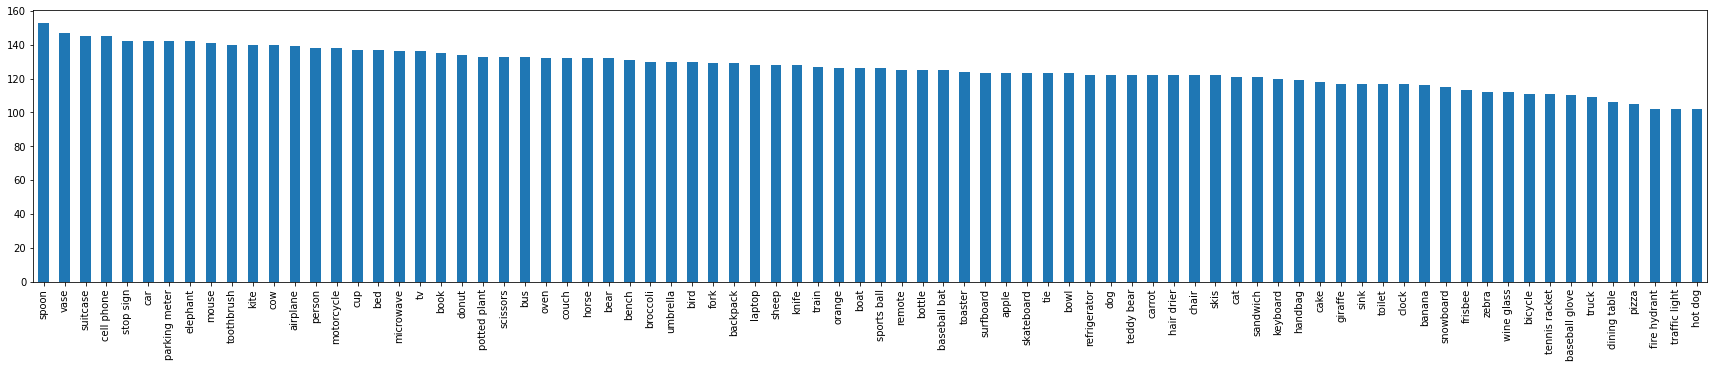

In [ ]:
plt.figure(figsize=(30, 5))
df['class_labels'].value_counts().plot(kind='bar')
plt.show()

## h/w visualization

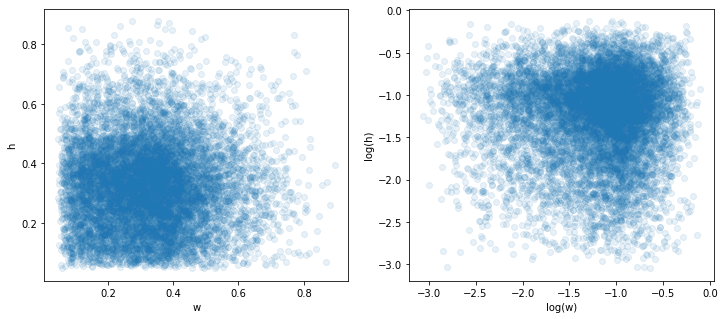

In [ ]:
h = coco_data[:, 6]/coco_data[:, 1]
w = coco_data[:, 5]/coco_data[:, 2]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(w, h, alpha=0.1)
plt.xlabel('w')
plt.ylabel('h')

plt.subplot(1, 2, 2) 
plt.scatter(np.log(w), np.log(h), alpha=0.1)
plt.xlabel('log(w)')
plt.ylabel('log(h)')

plt.show()

# K-Means clustering

In [ ]:
import time
import torch
from matplotlib import pyplot as plt

In [ ]:
use_cuda = torch.cuda.is_available()
dtype = torch.float32 if use_cuda else torch.float64

In [ ]:
def KMeans(x, K=10, Niter=10, verbose=True):

    """Implements Lloyd's algorithm for the Euclidean metric."""

    start = time.time()
    N, D = x.shape  # Number of samples, dimension of the ambient space

    c = x[:K, :].clone()  # Simplistic initialization for the centroids

    x_i = x.view(N, 1, D)  # (N, 1, D) samples
    c_j = c.view(1, K, D)  # (1, K, D) centroids

    # K-means loop:
    # - x  is the (N, D) point cloud,
    # - cl is the (N,) vector of class labels
    # - c  is the (K, D) cloud of cluster centroids
    
    for i in range(Niter):

        # E step: assign points to the closest cluster -------------------------
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (N, K) symbolic squared distances
        cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

        # M step: update the centroids to the normalized cluster average: ------
        # Compute the sum of points per cluster:
        c.zero_()
        c.scatter_add_(0, cl[:, None].repeat(1, D), x)

        # Divide by the number of points per cluster:
        Ncl = torch.bincount(cl, minlength=K).type_as(c).view(K, 1)
        c /= Ncl  # in-place division to compute the average

    if verbose:  
        if use_cuda:
            torch.cuda.synchronize()
        end = time.time()
        print(
            f"K-means for the Euclidean metric with {N:,} points in dimension {D:,}, K = {K:,}:"
        )
        print(
            "Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n".format(
                Niter, end - start, Niter, (end - start) / Niter
            )
        )

    return cl, c

In [ ]:
x = torch.Tensor(np.transpose(np.array([np.log(h), np.log(w)])))
x.shape

torch.Size([10105, 2])

K-means for the Euclidean metric with 10,105 points in dimension 2, K = 3:
Timing for 10 iterations: 0.06305s = 10 x 0.00631s



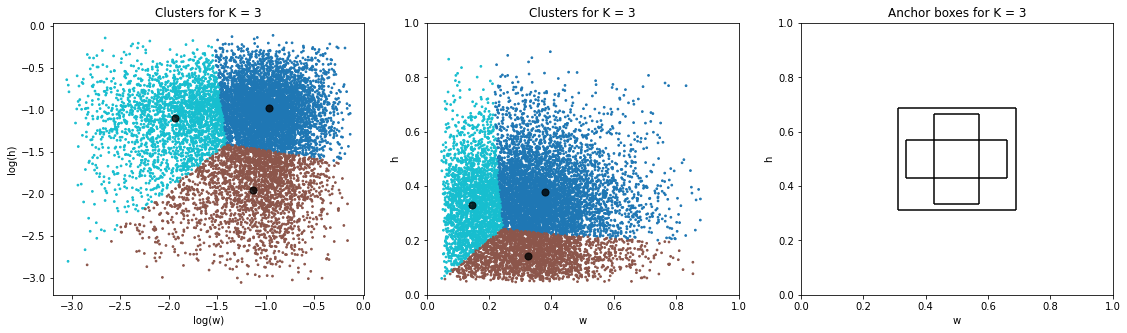

K-means for the Euclidean metric with 10,105 points in dimension 2, K = 4:
Timing for 10 iterations: 0.08928s = 10 x 0.00893s



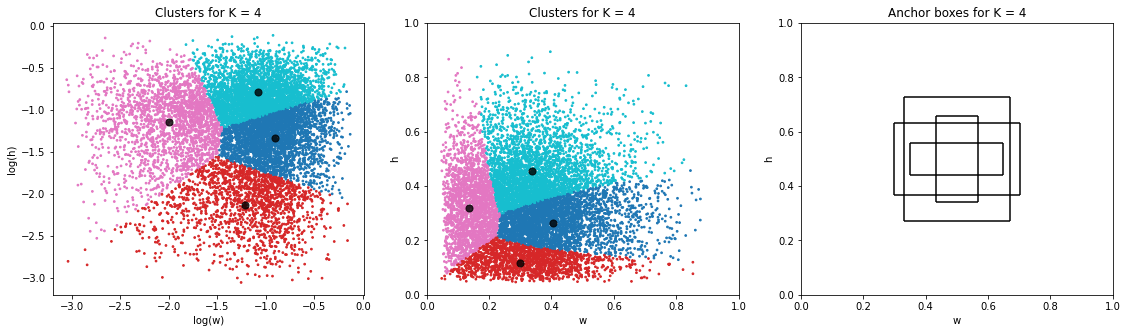

K-means for the Euclidean metric with 10,105 points in dimension 2, K = 5:
Timing for 10 iterations: 0.05801s = 10 x 0.00580s



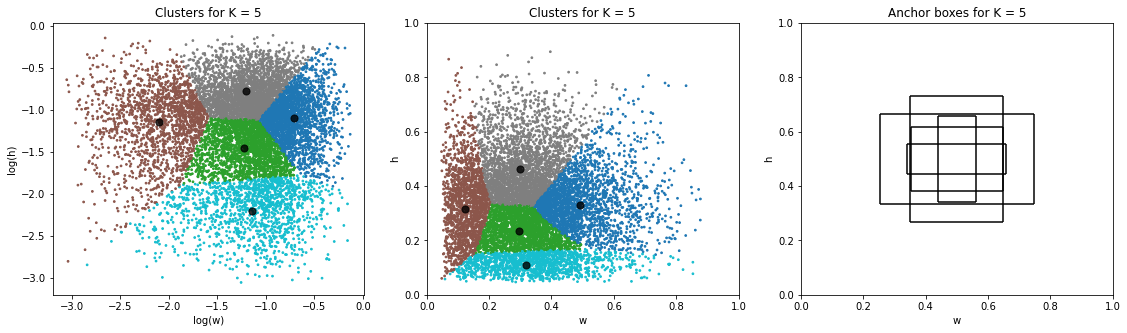

K-means for the Euclidean metric with 10,105 points in dimension 2, K = 6:
Timing for 10 iterations: 0.05584s = 10 x 0.00558s



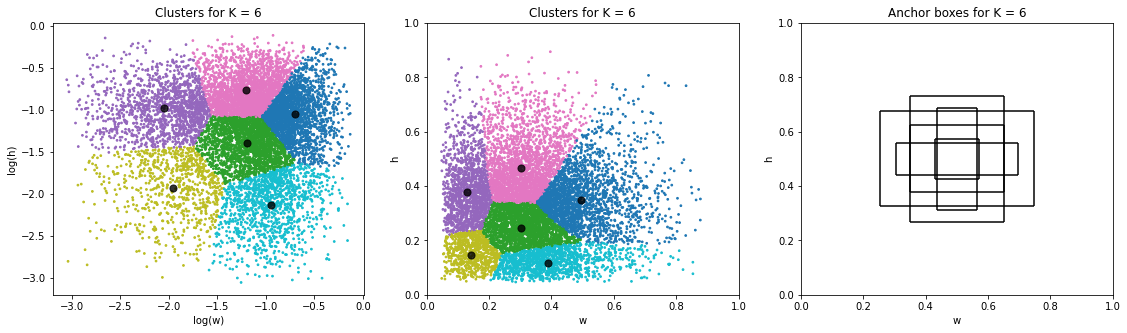

In [ ]:
for K in [3, 4, 5, 6]:

  # cl --> class label from 0 to K-1, c --> centroid points for each cluster from 0 to K-1
  cl, c = KMeans(x, K)

  plt.figure(figsize=(19, 5))

  plt.subplot(1, 3, 1).set_title('Clusters for K = '+str(K))
  
  plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=cl.cpu(), s=30000 / len(x), cmap="tab10")
  plt.scatter(c[:, 0].cpu(), c[:, 1].cpu(), c="black", s=50, alpha=0.8)
  plt.xlabel('log(w)')
  plt.ylabel('log(h)')

  plt.subplot(1, 3, 2).set_title('Clusters for K = '+str(K))
  plt.xlim(0, 1)
  plt.ylim(0, 1)

  plt.scatter(np.exp(x[:, 0].cpu()), np.exp(x[:, 1].cpu()), c=cl.cpu(), s=30000 / len(x), cmap="tab10")
  plt.scatter(np.exp(c[:, 0].cpu()), np.exp(c[:, 1].cpu()), c="black", s=50, alpha=0.8)
  plt.xlabel('w')
  plt.ylabel('h')

  plt.subplot(1, 3, 3).set_title('Anchor boxes for K = '+str(K))
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.xlabel('w')
  plt.ylabel('h')
  
  for i in range(K):
    w, h = np.exp(c[i, :].cpu().numpy())
    xmin, xmax = 0.5 - w/2, 0.5 + w/2
    ymin, ymax = 0.5 - h/2, 0.5 + h/2
    
    print(xmin, xmax, ymin, ymax)
    
    plt.hlines(ymin, xmin, xmax, colors='black')
    plt.hlines(ymax, xmin, xmax, colors='black')
    plt.vlines(xmin, ymin, ymax, colors='black')
    plt.vlines(xmax, ymin, ymax, colors='black')

  plt.show()